<a href="https://colab.research.google.com/github/SatioO/DL_Practices/blob/master/DeepLabV3_TF2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from IPython.display import clear_output
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

tf.random.set_seed(42)
np.random.seed(1)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

!unzip "/content/drive/My Drive/Launch pad/tfrecords.zip"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Archive:  /content/drive/My Drive/Launch pad/tfrecords.zip
   creating: tfrecords/
  inflating: tfrecords/train-00002-of-00004.tfrecord  
  inflating: tfrecords/val-00002-of-00004.tfrecord  
  inflating: tfrecords/train-00003-of-00004.tfrecord  
  inflating: tfrecords/val-00003-of-00004.tfrecord  
  inflating: tfrecords/train-00000-of-00004.tfrecord  
  inflating: tfrecords/val-00000-of-00004.tfrecord  
  inflating: tfrecords/train-00001-of-00004.tfrecord  
  

In [0]:
def data_generator(dataset, is_training, img_height=224, img_width=224, batch_size=16, buffer_size=5000):
    @tf.function
    def parse_fn(example_proto):
        features = {
            'image/filename':
                tf.io.FixedLenFeature((), tf.string, default_value=''),
            'image/encoded':
                tf.io.FixedLenFeature((), tf.string, default_value=''),
            'label/filename':
                tf.io.FixedLenFeature((), tf.string, default_value=''),
            'label/encoded':
                tf.io.FixedLenFeature((), tf.string, default_value=''),
        }

        parsed_feature = tf.io.parse_single_example(example_proto, features)

        img = tf.io.parse_tensor(parsed_feature['image/encoded'], tf.float32)
        img = tf.reshape(img, [img_height, img_width, 3])
        img = tf.clip_by_value(img, 0, 255)
        img = tf.image.per_image_standardization(img)

        mask = tf.io.parse_tensor(parsed_feature['label/encoded'], tf.uint8)
        mask = tf.reshape(mask, [img_height, img_width, 1])

        return img, mask

    def flip(img, mask):
        img = tf.image.random_flip_left_right(img, seed=1)
        mask = tf.image.random_flip_left_right(mask, seed=1)

        return img, mask

    def color(img, mask):
        img = tf.image.random_hue(img, 0.05)
        img = tf.image.random_saturation(img, 0.4, 1.2)
        img = tf.image.random_brightness(img, 0.05)
        img = tf.image.random_contrast(img, 0.4, 1.2)

        return img, mask

    dataset = tf.data.TFRecordDataset(dataset)
    if is_training:
        dataset = dataset.shuffle(buffer_size)
        dataset = dataset.repeat(buffer_size)
    dataset = dataset.map(
        parse_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    augmentations = [flip, color]

    if is_training:
        for f in augmentations:
            if tf.random.uniform([1], 0, 1) > 0.6:
                dataset = dataset.map(
                    f, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

    return dataset

In [0]:
def Upsample(tensor, size):
    '''bilinear upsampling'''
    name = tensor.name.split('/')[0] + '_upsample'

    def bilinear_upsample(x, size):
        resized = tf.image.resize(
            images=x, size=size)
        return resized
    y = layers.Lambda(lambda x: bilinear_upsample(x, size),
                      output_shape=size, name=name)(tensor)
    return y


def ASPP(img_input):
    # atrous spatial pyramid pooling
    dims = keras.backend.int_shape(img_input)

    # pool_1x1conv2d
    img_pool = layers.AveragePooling2D(pool_size=(
        dims[1], dims[2]), name='average_pooling')(img_input)
    img_pool = layers.Conv2D(filters=256, kernel_size=1, padding='same',
                             kernel_initializer='he_normal', name='pool_1x1conv2d', use_bias=False)(img_pool)
    img_pool = layers.BatchNormalization(name='bn_1')(img_pool)
    img_pool = layers.Activation('relu', name='relu_1')(img_pool)

    img_pool = Upsample(tensor=img_pool, size=[dims[1], dims[2]])

    # atrous 1
    y_1 = layers.Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
                        kernel_initializer='he_normal', name='ASPP_conv2d_d1', use_bias=False)(img_input)
    y_1 = layers.BatchNormalization(name='bn_2')(y_1)
    y_1 = layers.Activation('relu', name='relu_2')(y_1)

    # atrous 6
    y_6 = layers.Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same',
                        kernel_initializer='he_normal', name='ASPP_conv2d_d6', use_bias=False)(img_input)
    y_6 = layers.BatchNormalization(name='bn_3')(y_6)
    y_6 = layers.Activation('relu', name='relu_3')(y_6)

    # atrous 12
    y_12 = layers.Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same',
                         kernel_initializer='he_normal', name='ASPP_conv2d_d12', use_bias=False)(img_input)
    y_12 = layers.BatchNormalization(name='bn_4')(y_12)
    y_12 = layers.Activation('relu', name='relu_4')(y_12)

    # atrous 18
    y_18 = layers.Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same',
                         kernel_initializer='he_normal', name='ASPP_conv2d_d18', use_bias=False)(img_input)
    y_18 = layers.BatchNormalization(name='bn_5')(y_18)
    y_18 = layers.Activation('relu', name='relu_5')(y_18)

    # concatenate sampled layers
    y = layers.Concatenate(name='ASPP_concat')(
        [img_pool, y_1, y_6, y_12, y_18])

    y = layers.Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same',
                      kernel_initializer='he_normal', name='ASPP_conv2d_final', use_bias=False)(y)
    y = layers.BatchNormalization(name=f'bn_final')(y)
    y = layers.Activation('relu', name=f'relu_final')(y)

    return y


def deeplabv3(img_height, img_width, n_classes):
    base_model = tf.keras.applications.ResNet50(input_shape=(img_height, img_width, 3),
                                                include_top=False, weights='imagenet'
                                                )
    base_model.trainable = True

    img_features = base_model.get_layer("conv5_block3_2_relu").output
    x_a = ASPP(img_features)

    x_a = Upsample(tensor=x_a, size=[img_height // 4, img_width // 4])
    x_b = base_model.get_layer("conv2_block3_2_relu").output
    x_b = layers.Conv2D(filters=48, kernel_size=1, padding='same',
                        kernel_initializer='he_normal', name='low_level_projection', use_bias=False)(x_b)
    x_b = layers.BatchNormalization(name=f'bn_low_level_projection')(x_b)
    x_b = layers.Activation('relu', name='low_level_activation')(x_b)

    x = layers.Concatenate(name='decoder_concat')([x_a, x_b])

    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
                      kernel_initializer='he_normal', name='decoder_conv2d_1', use_bias=False)(x)
    x = layers.BatchNormalization(name=f'bn_decoder_1')(x)
    x = layers.Activation('relu', name='activation_decoder_1')(x)

    x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',
                      kernel_initializer='he_normal', name='decoder_conv2d_2', use_bias=False)(x)
    x = layers.BatchNormalization(name=f'bn_decoder_2')(x)
    x = layers.Activation('relu', name='activation_decoder_2')(x)

    x = Upsample(x, [img_height, img_width])
    x = layers.Conv2D(n_classes, (1, 1), name='output_layer')(x)

    return keras.Model(base_model.input, x, name="deeplabv3")

In [0]:
data_dir = "/content/tfrecords"

img_width = 224
img_height = 224
n_classes = 34
batch_size = 8


# Prepare data for training
train_ds = tf.data.Dataset.list_files(
    os.path.join(data_dir, "train-*.tfrecord"))
val_ds = tf.data.Dataset.list_files(
    os.path.join(data_dir, "val-*.tfrecord"))

train_batches = data_generator(
    train_ds, is_training=True, img_height=img_height, img_width=img_width, batch_size=batch_size)
val_batches = data_generator(
    val_ds, is_training=False, img_height=img_height, img_width=img_width, batch_size=batch_size)

original [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]


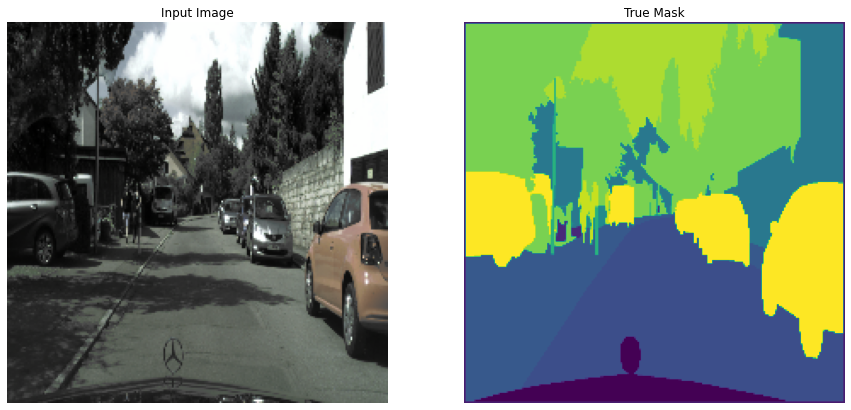

In [5]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        if i == 1:
          print("original", np.unique(display_list[i]))
        if i == 2:
          print("mask", np.unique(display_list[i]))

        plt.axis('off')
    plt.show()


def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])


class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))


# Visualize sample
for image, mask in train_batches.take(1):
    sample_image, sample_mask = image[0], mask[0]
display([sample_image, sample_mask])

original [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
mask [ 1  2  3  4  5  6  7  8 11 13 17 21 23 24 26]


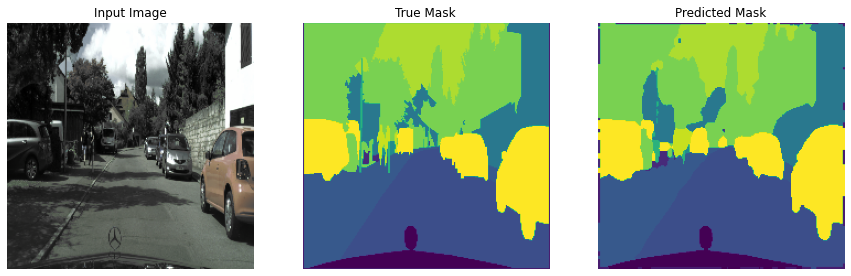


Sample Prediction after epoch 79

371/371 [==============================] - 56s 151ms/step - accuracy: 0.9254 - loss: 0.2170 - val_accuracy: 0.8373 - val_loss: 0.7334
Epoch 80/300
207/371 [===============>..............] - ETA: 23s - accuracy: 0.9254 - loss: 0.2171

KeyboardInterrupt: ignored

In [7]:
# Prepare model for training
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = deeplabv3(img_height, img_width, n_classes)

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.momentum = 0.9997
            layer.epsilon = 1e-5
        elif isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = tf.keras.regularizers.l2(1e-4)

    model.compile(loss=loss,
                  optimizer=tf.optimizers.Adam(learning_rate=1e-4),
                  metrics=['accuracy'])

tb = TensorBoard(log_dir='logs', write_graph=True, update_freq='batch')
mc = ModelCheckpoint(mode='min', filepath='top_weights.h5',
                      monitor='val_loss',
                      save_best_only='True',
                      save_weights_only='True', verbose=1)
dc = DisplayCallback()
callbacks = [mc, tb, dc]

history = model.fit(train_batches,
          steps_per_epoch=2975 // batch_size,
          epochs=300,
          validation_data=val_batches,
          validation_steps=500 // batch_size,
          callbacks=callbacks)

original [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
mask [ 1  2  3  4  5  6  7  8 11 13 17 19 20 21 23 24 26 28 31 33]


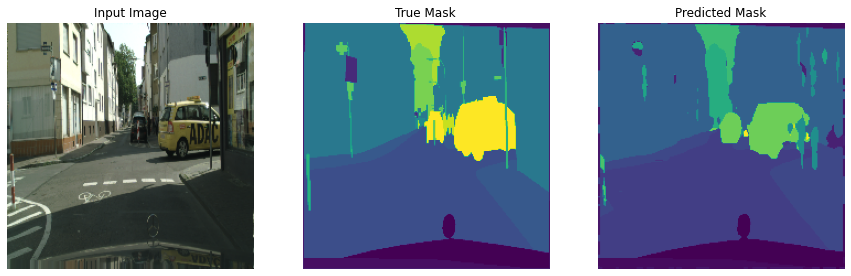

original [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
mask [ 1  2  3  4  5  6  7  8 11 12 13 14 17 19 20 21 22 23 26 27 28 33]


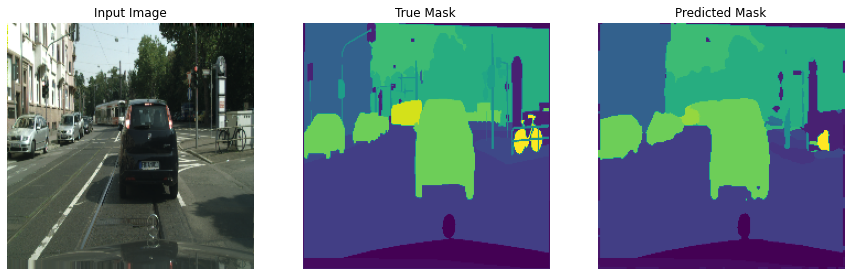

original [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 33]
mask [ 1  2  3  4  5  6  7  8 11 12 17 19 20 21 22 23 25 26 33]


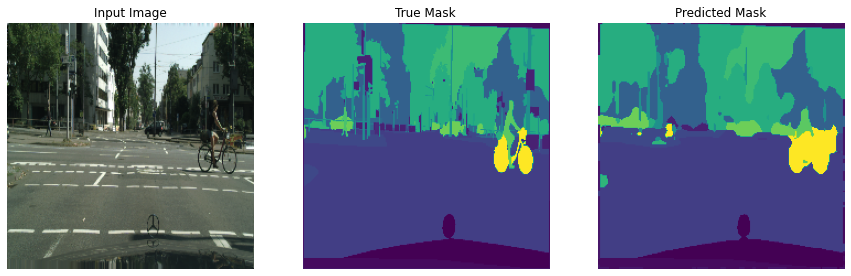

original [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 27 28 29 30 32]
mask [ 1  2  3  4  5  6  7  8  9 11 12 13 17 20 21 23 24]


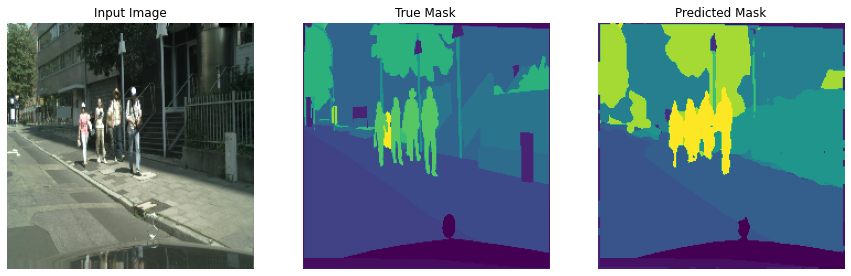

original [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 33]
mask [ 1  2  3  4  5  6  7  8 10 11 17 20 21 22 23 25 26 27 28 32]


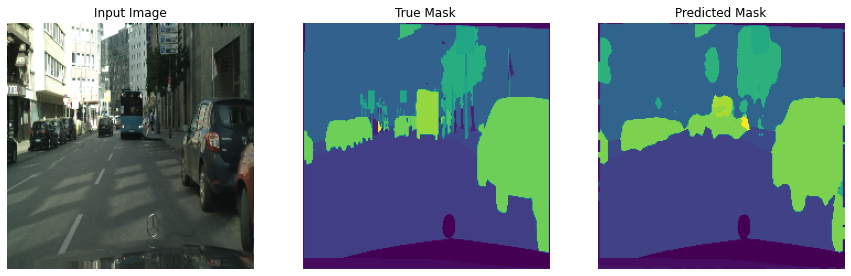

original [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
mask [ 1  2  3  4  5  6  7  8 11 12 13 17 19 20 21 22 23 26 27 28 32 33]


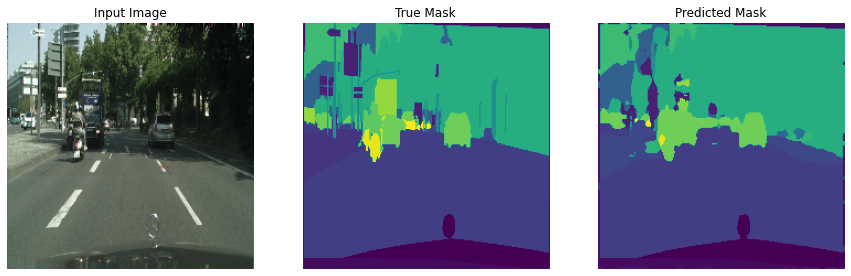

original [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
mask [ 1  2  3  4  5  6  7  8 11 12 13 17 19 20 21 23 24 25 26 32 33]


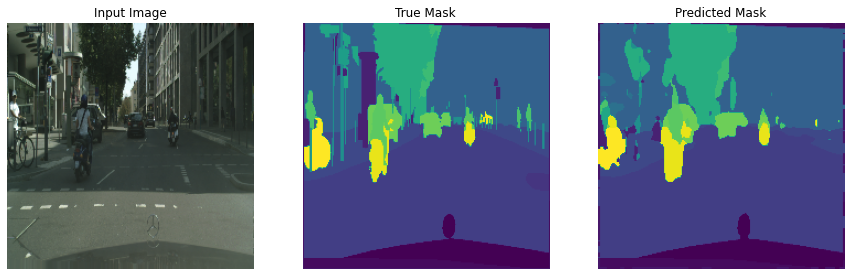

original [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
mask [ 1  2  3  4  5  6  7  8  9 11 12 13 17 21 22 23 24 25 26 33]


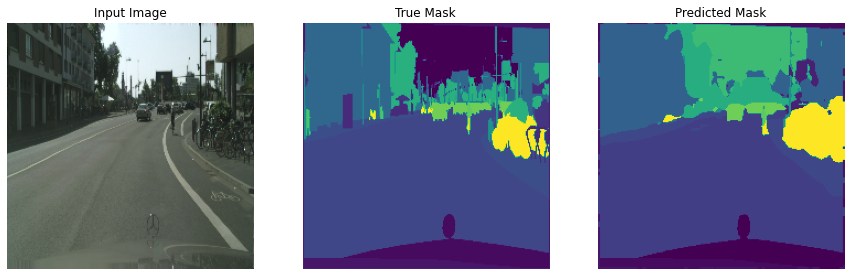

original [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]
mask [ 1  2  3  4  5  6  7  8  9 11 12 13 17 19 20 21 22 23 24 26]


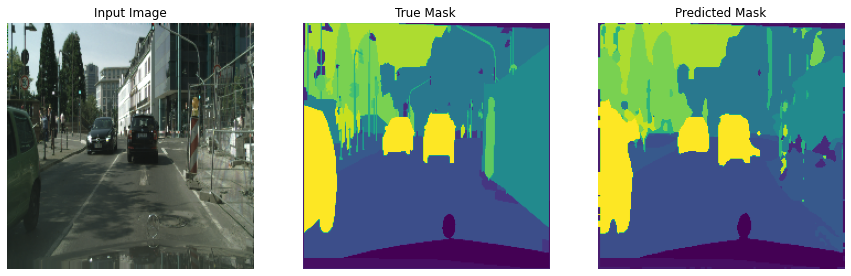

original [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
mask [ 1  2  3  4  5  6  7  8 10 11 12 13 17 19 20 21 23 24 25 26 28 33]


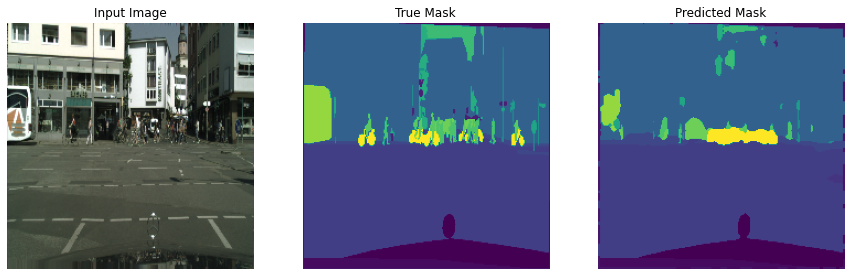

In [9]:
show_predictions(val_batches, 10)